In [ ]:
import chess
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

# 定义棋子类型到索引的映射 (6维)
PIECE_TO_INDEX = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5,
}

# --- 静态边索引创建辅助函数 ---
# 这些函数只创建一次，因为在Zięba的模型中，图的连接性是静态的
# 它们代表棋子在空棋盘上的“潜在”移动能力

def _get_rook_edges(square: int) -> List[int]:
    """获取指定格子作为车(Rook)时的所有潜在移动目标格"""
    edges = []
    file, rank = chess.square_file(square), chess.square_rank(square)
    for i in range(8):
        if i != file:
            edges.append(chess.square(i, rank))
        if i != rank:
            edges.append(chess.square(file, i))
    return edges

def _get_bishop_edges(square: int) -> List[int]:
    """获取指定格子作为象(Bishop)时的所有潜在移动目标格"""
    edges = []
    file, rank = chess.square_file(square), chess.square_rank(square)
    for i in range(1, 8):
        # 右上, 左下, 左上, 右下
        if chess.square_file(square) + i < 8 and chess.square_rank(square) + i < 8:
            edges.append(square + i * 9)
        if chess.square_file(square) - i >= 0 and chess.square_rank(square) - i >= 0:
            edges.append(square - i * 9)
        if chess.square_file(square) - i >= 0 and chess.square_rank(square) + i < 8:
            edges.append(square + i * 7)
        if chess.square_file(square) + i < 8 and chess.square_rank(square) - i >= 0:
            edges.append(square - i * 7)
    return edges

def _get_knight_moves(square: int) -> List[int]:
    """获取指定格子作为马(Knight)时的所有潜在移动目标格"""
    edges = []
    file, rank = chess.square_file(square), chess.square_rank(square)
    # 所有8个马步方向
    offsets = [(1, 2), (1, -2), (-1, 2), (-1, -2),
               (2, 1), (2, -1), (-2, 1), (-2, -1)]
    for f_off, r_off in offsets:
        new_file, new_rank = file + f_off, rank + r_off
        if 0 <= new_file < 8 and 0 <= new_rank < 8:
            edges.append(chess.square(new_file, new_rank))
    return edges

def _create_static_edge_index() -> np.ndarray:
    edges = []
    for square in range(64):
        # 1. Queen's moves (Rook + Bishop)
        queen_moves = _get_rook_edges(square) + _get_bishop_edges(square)
        for move in set(queen_moves):
            edges.append((square, move))

        # 2. Knight's moves
        for move in _get_knight_moves(square):
            edges.append((square, move))
            
        # 3. Add self-loops for every node
        edges.append((square, square))

    # 转换为COO格式 (Coordinate list)
    edge_index = np.array(list(set(edges))).T
    return edge_index

# --- 主编码函数 ---

def encode_board_to_gnn_input(board: chess.Board) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    根据Zięba的ChessGNN论文，将一个 `python-chess` 的Board对象编码为GNN的输入。

    返回:
        - node_features (np.ndarray): 形状为 [64, 12] 的节点特征矩阵。
        - edge_index (np.ndarray): 形状为 [2, N] 的边索引 (COO格式)。
        - global_features (np.ndarray): 形状为 [8] 的全局特征向量。
    """
    node_features = np.zeros((64, 12), dtype=np.float32)

    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            node_features[i, PIECE_TO_INDEX[piece.piece_type]] = 1
            node_features[i, 6 + piece.color] = 1

        # ========================= #
        # === 代码修正处 === #
        # ========================= #
        # 格子颜色 (0 for dark, 1 for light)。
        # (行索引 + 列索引) % 2 != 0 为亮色格 (例如 b1, a2)
        # a1 (索引0) 的 file=0, rank=0, 0+0=0, 是暗色格。
        if (chess.square_file(i) + chess.square_rank(i)) % 2 != 0:
            node_features[i, 8] = 1 # 亮色格为1

        # 格子坐标 (归一化到 [0, 1])
        node_features[i, 9] = chess.square_file(i) / 7.0
        node_features[i, 10] = chess.square_rank(i) / 7.0

        # 可被吃过路兵的格
        if board.ep_square is not None and i == board.ep_square:
            node_features[i, 11] = 1

    edge_index = _create_static_edge_index()
    global_features = np.zeros(8, dtype=np.float32)

    global_features[0 if board.turn == chess.WHITE else 1] = 1
    if board.has_kingside_castling_rights(chess.WHITE): global_features[2] = 1
    if board.has_queenside_castling_rights(chess.WHITE): global_features[3] = 1
    if board.has_kingside_castling_rights(chess.BLACK): global_features[4] = 1
    if board.has_queenside_castling_rights(chess.BLACK): global_features[5] = 1
    global_features[6] = min(board.halfmove_clock, 100) / 100.0
    if board.is_repetition():
        global_features[7] = 1

    return node_features, edge_index, global_features

# --- 示例 ---
if __name__ == '__main__':
    # 使用一个具体的局面进行测试 (西西里防御开局后几步)
    board = chess.Board("rnbqkbnr/ppp1p1pp/8/3pPp2/8/8/PPPP1PPP/RNBQKBNR w KQkq f6 0 3")
    print("当前棋盘 (FEN):")
    print(board.fen())
    print("\n棋盘可视化:")
    print(board)

    # 编码
    nodes, edges, g_features = encode_board_to_gnn_input(board)

    print("\n--- Zięba's ChessGNN 编码结果 ---")
    print(f"节点特征矩阵 (Node Features) shape: {nodes.shape}")
    print(f"边索引 (Edge Index) shape: {edges.shape}")
    print(f"全局特征向量 (Global Features) shape: {g_features.shape}")

    print("\n全局特征向量详解:")
    print(f"[White Turn, Black Turn]: [{g_features[0]}, {g_features[1]}]")
    print(f"[WK, WQ, BK, BQ]: [{g_features[2]}, {g_features[3]}, {g_features[4]}, {g_features[5]}]")
    print(f"Normalized Half-move Clock: {g_features[6]:.2f}")
    print(f"Is Repetition: {g_features[7]}")
    
    print(f"\n静态边索引中的总边数 (包括自循环): {edges.shape[1]}")

    # 检查一个具体节点的特征 (e4格子上的白兵)
    e4_square_index = chess.E4
    e4_node_features = nodes[e4_square_index]
    print(f"\nE4格 (索引 {e4_square_index}) 的节点特征向量 (12维):")
    print(e4_node_features)
    # e4是暗色格, (file 4 + rank 3) % 2 = 7 % 2 = 1, 所以是亮色格.
    # a1 = (0,0) sum=0 dark
    # b1 = (1,0) sum=1 light
    # e4 = (4,3) sum=7 light
    print("  - 棋子类型(兵): [1. 0. 0. 0. 0. 0.] (索引0为1)")
    print("  - 棋子颜色(白): [1. 0.] (索引6为1)")
    print(f"  - 格子颜色(亮): [{e4_node_features[8]}] (索引8为1)")
    print(f"  - 归一化坐标: [{e4_node_features[9]:.2f} {e4_node_features[10]:.2f}] (File e, Rank 4)")
    print("  - 非吃过路兵格: [0.]")

当前棋盘 (FEN):
rnbqkbnr/ppp1p1pp/8/3pPp2/8/8/PPPP1PPP/RNBQKBNR w KQkq f6 0 3

棋盘可视化:
r n b q k b n r
p p p . p . p p
. . . . . . . .
. . . p P p . .
. . . . . . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

--- Zięba's ChessGNN 编码结果 ---
节点特征矩阵 (Node Features) shape: (64, 12)
边索引 (Edge Index) shape: (2, 1856)
全局特征向量 (Global Features) shape: (8,)

全局特征向量详解:
[White Turn, Black Turn]: [1.0, 0.0]
[WK, WQ, BK, BQ]: [1.0, 1.0, 1.0, 1.0]
Normalized Half-move Clock: 0.00
Is Repetition: 0.0

静态边索引中的总边数 (包括自循环): 1856

E4格 (索引 28) 的节点特征向量 (12维):
[0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.5714286  0.42857143 0.        ]
  - 棋子类型(兵): [1. 0. 0. 0. 0. 0.] (索引0为1)
  - 棋子颜色(白): [1. 0.] (索引6为1)
  - 格子颜色(亮): [1.0] (索引8为1)
  - 归一化坐标: [0.57 0.43] (File e, Rank 4)
  - 非吃过路兵格: [0.]


In [62]:
def index_of(arr, value):
    for i in range(len(arr)):
        if arr[i] == value:
            return i
    
    return -1

In [ ]:
print(nodes.shape)
print(edges.shape)

(64, 12)
(2, 1856)
[[0.         0.         0.         1.         0.         0.
  0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         1.         1.         0.14285715 0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         1.         0.         0.2857143  0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         1.         1.         0.42857143 0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         1.         0.         0.5714286  0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         1.         1.         0.71428573 0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         1.         0.         0.85714287 0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         1.   

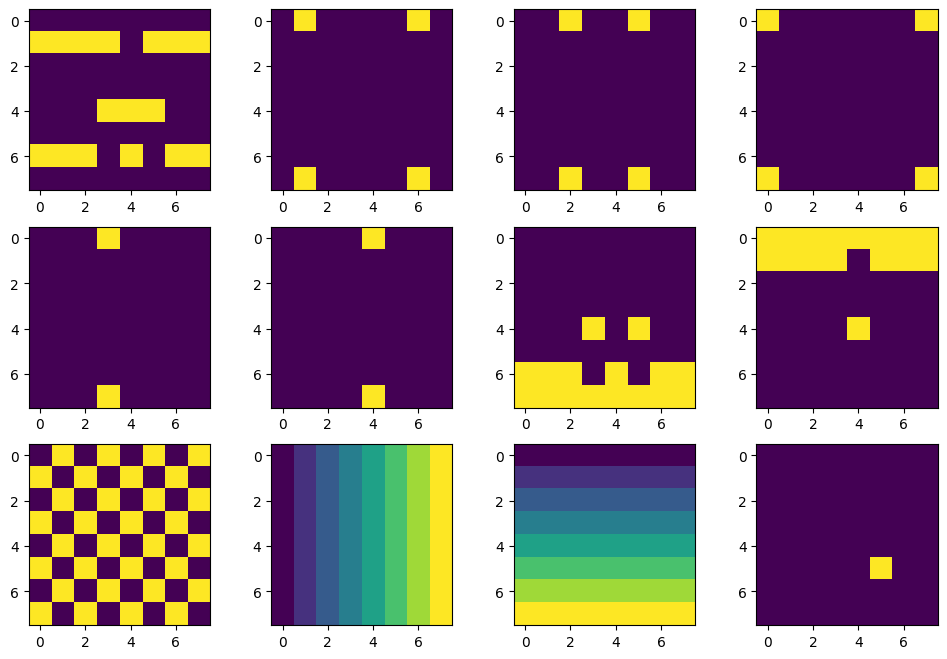

In [20]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(nodes[:, i].reshape(8, 8))

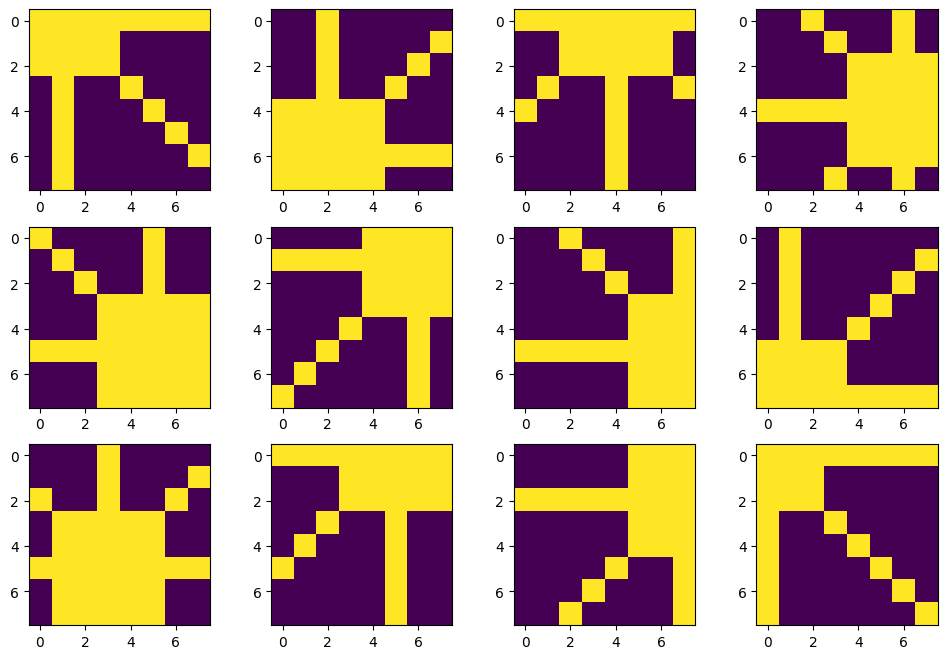

In [64]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

arr1 = np.zeros((12, 64))

arr2 = np.random.randint(64, size=(12))
while len(set(arr2)) != 12:
    arr2 = np.random.randint(64, size=(12))

for i in range(len(arr2)):
    for j in range(edges.shape[1]):
        index = index_of(arr2, edges[0, j])
        if index != -1:
            arr1[index, edges[1, j]] = 1

for i, ax in enumerate(axs.flat):
    ax.imshow(arr1[i].reshape(8, 8))

